## Reduce dimension of image

Image shape: (680, 480, 3)


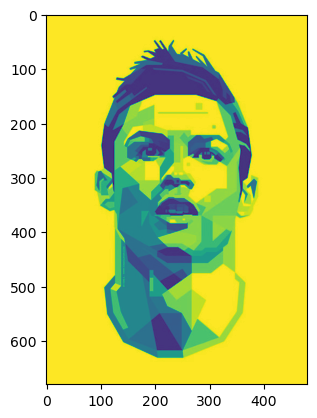

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.linalg as ln
from PIL import Image
import urllib.request
from io import BytesIO

%matplotlib inline

url = str('https://static.bongda24h.vn/medias/standard/2020/7/28/Anh-CR7_-9.jpg')
with urllib.request.urlopen(url) as url:
    f = BytesIO(url.read())

ig = np.array(Image.open(f))
print('Image shape: %s'%str(ig.shape))
# Convert to grey
ig = ig.dot([0.299, 0.5870, 0.114])
plt.imshow(ig)

In [16]:
def SVD_pic(n_evl,ig):
    """
    n_evl : the number of highest eigenvalues taken
    """
    
    # Take shape 
    m = ig.shape[0]
    n = ig.shape[1]
    
    # SVD
    
    U, S_diag ,VT = ln.svd(ig) # S sorted ascending
    
    # Reduce dimension
    S_diag = S_diag[:n_evl]
    S = np.zeros((n_evl,n_evl))
    U_new = U[:,:n_evl]
    VT_new = VT[:n_evl, :]
    np.fill_diagonal(S, S_diag)
    
    #New_pic
    ig_new = U_new@S@VT_new
    plt.imshow(ig_new)
    
    fb = ln.norm(ig_new - ig , 'fro') # sigma t+1 - > n
    
    retain = (1 - fb**2/np.sum(S**2))*100
    
    print('Percentage of information retained: %.2f%s \n'%(retain, '%'))
    
    
    

Keep  10  dimemsion 
Percentage of information retained: 99.35% 

Keep  20  dimemsion 
Percentage of information retained: 99.66% 

Keep  30  dimemsion 
Percentage of information retained: 99.79% 

Keep  40  dimemsion 
Percentage of information retained: 99.86% 

Keep  50  dimemsion 
Percentage of information retained: 99.91% 

Keep  60  dimemsion 
Percentage of information retained: 99.93% 

Keep  70  dimemsion 
Percentage of information retained: 99.95% 

Keep  80  dimemsion 
Percentage of information retained: 99.96% 

Keep  90  dimemsion 
Percentage of information retained: 99.97% 

Keep  100  dimemsion 
Percentage of information retained: 99.98% 

Keep  110  dimemsion 
Percentage of information retained: 99.98% 

Keep  120  dimemsion 
Percentage of information retained: 99.99% 

Keep  130  dimemsion 
Percentage of information retained: 99.99% 

Keep  140  dimemsion 
Percentage of information retained: 99.99% 

Keep  150  dimemsion 
Percentage of information retained: 99.99% 

Keep

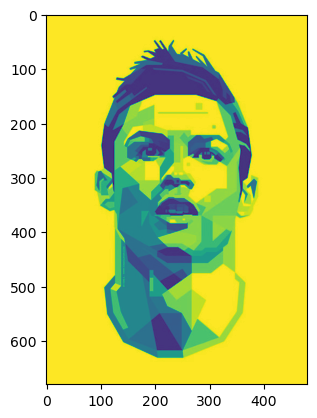

In [42]:
n_max = ig.shape[1]

for i in range(10,n_max,10):
    print("Keep ", i , " dimemsion ")
    SVD_pic(i,ig)

Percentage of information retained: 99.35% 



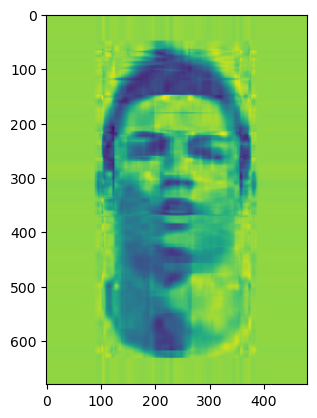

In [43]:
SVD_pic(10,ig)

Percentage of information retained: 99.66% 



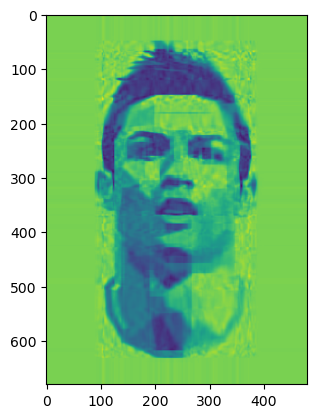

In [44]:
SVD_pic(20,ig)

Như vậy với 10 trị riêng lớn nhất đã thể hiện được được 99.35% thông tin bức ảnh và với 20 trị riêng lớn nhất thể hiện được 99.66% thông tin bức ảnh. So với bức ảnh gốc ta phải lưu trữ ma trận có kích thước là 680x480. Trong khi với 20 chiều vector ta chỉ phải lưu trữ các ma trận  Ut,Vt
  có kích thước là 680x20, 20x480 và ma trận  S
  có kích thước là 20x20. Giả định mỗi phần tử của ma trận được lưu với cùng số byte. Như vậy số lượng thông tin ta cần lưu chỉ là:
  
$$\frac{680×20+20×480+20×20}{680×480}=7\%$$
 
Dó đó phương pháp truncate SVD thường được sử dụng trong nén thông tin rất hiệu quả.

## Recommend System

In [46]:
class Data(object):
    """
    This class used to manage data.
    Two arguments:
    dataset: pandas data frame include user_id, item_id and rating
    split_rate: number train ratings/ total ratings
    """
    def __init__(self, dataset, split_rate):
        self.dataset = dataset
        self.split_rate = split_rate
        self.train, self.test = self.split_train_test(self.dataset)
        self.n_users = np.max(self.train[:, 0] + 1) #plus one because index start from 0
        self.n_items = np.max(self.train[:, 1] + 1)
        self.Ytrain, self.Rtrain = self.utility_matrix(self.train)
        self.Ytest , self.Rtest  = self.utility_matrix(self.test)
        self.Ystad,  self.u_mean = self.standardize_Y(self.Ytrain)
        self.n_ratings = self.train.shape[0]
        
    def split_train_test(self, dataset):
        "split train and test"
        gb = dataset.groupby('user_id')
        ls = [gb.get_group(x) for x in gb.groups]
        items = [x for x in gb.groups]
        index_size = [{'i': i, 'index':gb.groups[i], 'size':len(gb.groups[i])} for i in items]
        index_train = pd.Int64Index([])
        index_test = pd.Int64Index([])
        for x in index_size:
            np.random.shuffle(x['index'].values)
            le = int(x['size']*self.split_rate)
            index_train = index_train.append(x['index'][:le])
            index_test = index_test.append(x['index'][le:])
        train = dataset.iloc[index_train].values
        test = dataset.iloc[index_test].values
        #minus id to 1 to index start from 0
        train[:, 0] -= 1
        train[:, 1] -= 1
        test[:, 0] -= 1
        test[:, 1] -= 1
        return train, test
    
    def utility_matrix(self, data_mtx):
        "create Y and R matrix"
        Y = np.zeros(shape = (self.n_items, self.n_users))
        Y = sparse.coo_matrix((data_mtx[:, 2], (data_mtx[:, 1], data_mtx[:, 0])), \
                              shape = (self.n_items, self.n_users), dtype = np.float).toarray()
        R = sparse.coo_matrix((np.ones((data_mtx.shape[0],)), (data_mtx[:, 1], data_mtx[:, 0])), \
                              shape = (self.n_items, self.n_users)).toarray()
        return Y, R
    
    def standardize_Y(self, Y):
        "standard data to mean ratings of each user = 0"
        sum_rating = Y.sum(axis = 0)
        u_rating = np.count_nonzero(Y, axis = 0)
        u_mean = sum_rating/u_rating
        for n in range(self.n_users):
            for m in range(self.n_items):
                if Y[m, n] != 0:
                    Y[m, n] -= u_mean[n]
        return Y, u_mean

In [47]:
class Model():
    """
    This class manage update U and I matrix, predict and evaluate error
    Two arguments:
    data: instance from Data class which supplies the data for model
    n_evl: number of eigenvalues
    """
    def __init__(self, data, n_evl = None):
        self.data = data
        self.n_evl = n_evl
        self.Yhat_std = self.fit(self.data, self.n_evl)
        self.Yhat = self.pred()
        
    def fit(self, data, n_evl):
        U, S, V = ln.svd(data.Ystad)
        #When n_evl is undefined, we set it equal to diagonal length
        if self.n_evl is None:
            n_evl = S.shape[0]
        #Get id position of n highest eigenvalues
        id_trunc = np.argsort(S)[::-1][:n_evl]
        #Extract matrix U_t, V_t, S_t
        U_t = U[np.ix_(np.arange(U.shape[0]), id_trunc)]
        V_t = V[np.ix_(id_trunc, np.arange(V.shape[1]))]
        S_diag = S[id_trunc]
        S_t = np.zeros((n_evl, n_evl))
        np.fill_diagonal(S_t, S_diag)
        #Return matrix forecast
        self.Yhat_std = np.dot(U_t, S_t.dot(V_t))
        return self.Yhat_std
    
    def pred(self):
        #invert to forecast values by plus user's mean ratings
        self.Yhat = self.Yhat_std.copy()
        for n in range(self.data.n_users):
            self.Yhat[:, n] += self.data.u_mean[n]
        #convert to interger values because of rating is integer
        self.Yhat = self.Yhat.astype(np.int32) 
        #replace values > 5 by 5 and values < 1 by 1
        self.Yhat[self.Yhat > 5] = 5
        self.Yhat[self.Yhat < 1] = 1
        return self.Yhat

    def pred_train_test(self, Yhat, R):
        #replace values have not yet rated by 0 
        Y_pred = Yhat.copy()
        Y_pred[R == 0] = 0
        return Y_pred
    
    def RMSE(self, Y, Yhat):
        error = Y - Yhat
        n_ratings = np.sum(Y != 0)
        rmse = math.sqrt(np.linalg.norm(error, 'fro')**2/n_ratings)
        return rmse

In [48]:
class MF():
    """
    This class used to manage model and data
    Two main arguments:
    data: control the data
    model: control the functions which execute model
    """
    def __init__(self, data, model):
        self.data = data
        self.model = model
        self.Y_pred_train = None
        self.Y_pred_test = None
        self.Yhat = None
        
    def fit(self):
        #fiting model
        self.model.fit(self.data, self.model.n_evl)
        #calculate Y_hat
        self.Yhat = self.model.pred()
        #calculate Y_pred_train by replace non ratings by 0
        self.Y_pred_train = self.model.pred_train_test(self.Yhat, self.data.Rtrain)
        self.Y_pred_test  = self.model.pred_train_test(self.Yhat, self.data.Rtest)
        print('RMSE: {}'.\
              format(self.model.RMSE(self.data.Ytest, self.Y_pred_test)))

    def recommend_for_user(self, user_id, k_neighbors):
        recm = np.concatenate((np.arange(1, self.Y_pred_test.shape[0]+1).reshape(-1, 1), \
                               self.Y_pred_test[:, user_id - 1].reshape(-1, 1)), axis = 1)
        recm.sort(axis = 0)
        print('Top %s item_id recommended to user_id %s: %s'%\
              (k_neighbors, user_id, str(recm[-k_neighbors:, 0])))

In [50]:
!kaggle datasets download -d odedgolden/movielens-1m-dataset

100%|██████████████████████████████████████| 5.83M/5.83M [00:03<00:00, 1.47MB/s]
100%|██████████████████████████████████████| 5.83M/5.83M [00:03<00:00, 1.71MB/s]


In [51]:
!unzip movielens-1m-dataset.zip

Archive:  movielens-1m-dataset.zip
  inflating: README                  
  inflating: movies.dat              
  inflating: ratings.dat             
  inflating: users.dat               


In [53]:
import numpy as np
import scipy.linalg as ln
import pandas as pd
import scipy.sparse as sparse
import math

columns = ['user_id', 'item_id', 'rating', 'timestamp']
movie_length = pd.read_csv('ratings.dat', header = 0, \
                           names = columns, sep = '::', engine = 'python')
movie_length = movie_length.sort_values(['user_id', 'item_id'])

data = Data(dataset = movie_length, split_rate = 2/3)

/var/folders/f2/kclshvmd72g57b3n4bt8pj980000gn/T/ipykernel_18958/3952957725.py:25: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  index_train = pd.Int64Index([])
/var/folders/f2/kclshvmd72g57b3n4bt8pj980000gn/T/ipykernel_18958/3952957725.py:26: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  index_test = pd.Int64Index([])
/var/folders/f2/kclshvmd72g57b3n4bt8pj980000gn/T/ipykernel_18958/3952957725.py:45: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sh

In [54]:
# Fitting model  
model = Model(data = data, n_evl = 2)
mf = MF(data = data, model = model)
mf.fit()

RMSE: 1.1423914008948484
